In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

/home/leon/.local/lib/python3.9/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
# все SNP с diffASE in vivo и in vitro хотя бы у одного человека
ase_vv = pd.read_csv("/media/leon/DISK2/icig/done/ase_snps.csv")
ase_vtr = pd.read_csv("/media/leon/DISK2/icig/done/ase_vtr_snps.csv")

ase_vv['dp_sum'] = ase_vv[['DP_0R', 'DP_1R', 'DP_30R', 'DP_90R']].fillna(0).sum(axis=1)
ase_vv = ase_vv.loc[ase_vv.groupby(['gene_id', 'patient'])['dp_sum'].idxmax()]
ase_vtr['dp_sum'] = ase_vtr[['DP_0R', 'DP_1R']].fillna(0).sum(axis=1)
ase_vtr = ase_vtr.loc[ase_vtr.groupby(['gene_id', 'id_sample_0R'])['dp_sum'].idxmax()]

In [4]:
# нормализованные каунты
res = pd.read_csv("/media/leon/DISK2/icig/done/res_df.csv")
res = res.dropna(axis=0)

# считаем среднее и дисперсию
srr_cols = [col for col in res.columns if col.startswith('SRR')]
res["baseMean"] = res[srr_cols].mean(axis=1)
res["variance"] = res[srr_cols].var(axis=1)

# считаем корень из дисперсии и делим на среднее
res["std"] = res.variance ** 0.5
res["CV"] = res["std"] / res.baseMean

# все SNP с diffASE in vivo и in vitro хотя бы у одного человека
ase_vv = pd.read_csv("/media/leon/DISK2/icig/done/ase_snps.csv")
ase_vtr = pd.read_csv("/media/leon/DISK2/icig/done/ase_vtr_snps.csv")

# вычисляем изменение асимметрии
ase_vv["FC"] = ((ase_vv.DP_1R * ase_vv.QS_ref_1R) / (ase_vv.DP_1R * ase_vv.QS_alt1_1R)) / ((ase_vv.DP_0R * ase_vv.QS_ref_0R) / (ase_vv.DP_0R * ase_vv.QS_alt1_0R))
ase_vtr["FC"] = ((ase_vtr.DP_1R * ase_vtr.QS_ref_1R) / (ase_vtr.DP_1R * ase_vtr.QS_alt1_1R)) / ((ase_vtr.DP_0R * ase_vtr.QS_ref_0R) / (ase_vtr.DP_0R * ase_vtr.QS_alt1_0R))

# выбираем SNP с наибольшим покрытием для каждого гена (?)
ase_vv['dp_sum'] = ase_vv[['DP_0R', 'DP_1R', 'DP_30R', 'DP_90R']].fillna(0).sum(axis=1)
ase_vv = ase_vv.loc[ase_vv.groupby(['gene_id', 'patient'])['dp_sum'].idxmax()]
ase_vtr['dp_sum'] = ase_vtr[['DP_0R', 'DP_1R']].fillna(0).sum(axis=1)
ase_vtr = ase_vtr.loc[ase_vtr.groupby(['gene_id', 'id_sample_0R'])['dp_sum'].idxmax()]

# усредняем FC, если ген встречается у нескольких людей
ase_vv_mean = ase_vv.groupby('gene_id', as_index=False)[['FC']].mean()
ase_vtr_mean = ase_vtr.groupby('gene_id', as_index=False)['FC'].mean()
combined = pd.concat([ase_vv_mean, ase_vtr_mean], ignore_index=True)
result = combined.groupby('gene_id', as_index=False).agg({'FC': 'mean'})

# всего 3693 гена с изменением АСЭ в мононуклеарах экспрессируются в поджелудочной железе
res = pd.merge(res, result, left_on='entrez', right_on='gene_id', how='inner')
print(len(res.gene_id))

# 1748 генов с FC > 3 * std / mean
res = res[res.FC > res.CV * 2]
print(len(res.gene_id))
# res.gene_id.to_csv("/media/leon/DISK2/icig/done/30.05.25.genelist.csv")

3602
1704


In [5]:
result.entrez = result.gene_id.fillna(0).apply(int).apply(str)
result = result.dropna(axis=0)
result

/tmp/ipykernel_4267/808872142.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  result.entrez = result.gene_id.fillna(0).apply(int).apply(str)


,gene_id,FC
0,16,1.620449
1,18,1.880039
2,20,1.242572
3,25,1.136639
4,27,2.299547
...,...,...
4872,127379753,2.034977
4873,127739546,2.082836
4874,127882475,1.593822
4875,128193293,0.879265


In [6]:
# все SNP с diffASE in vivo и in vitro хотя бы у одного человека
ase_vv = pd.read_csv("/media/leon/DISK2/icig/done/ase_snps.csv")
ase_vtr = pd.read_csv("/media/leon/DISK2/icig/done/ase_vtr_snps.csv")
ase_vtr = ase_vtr.rename(columns={'id_sample_0R': 'patient'})
ase_vtr.patient = [i.split('_')[1] for i in ase_vtr.patient]

# выбираем SNP с наибольшим покрытием для каждого гена (?)
ase_vv['dp_sum'] = ase_vv[['DP_0R', 'DP_1R', 'DP_30R', 'DP_90R']].fillna(0).sum(axis=1)
ase_vv = ase_vv.loc[ase_vv.groupby(['gene_id', 'patient'])['dp_sum'].idxmax()]
ase_vtr['dp_sum'] = ase_vtr[['DP_0R', 'DP_1R']].fillna(0).sum(axis=1)
ase_vtr = ase_vtr.loc[ase_vtr.groupby(['gene_id', 'patient'])['dp_sum'].idxmax()]

# ase_vv.to_csv("/media/leon/DISK2/icig/done/ase_snps.csv")
# ase_vtr.to_csv("/media/leon/DISK2/icig/done/ase_vtr_snps.csv")

In [7]:
combined_df = pd.concat([ase_vtr, ase_vv], axis=0, sort=False)
combined_df['dataset'] = combined_df.patient.apply(lambda x: "in_vitro" if x[1] in "ADBK" else "in_vivo")
combined_df

,chr,pos,gene_id,patient,DP_0R,ref_0R,QS_ref_0R,alt1_0R,QS_alt1_0R,alt2_0R,...,QS_ref_90R,alt1_90R,QS_alt1_90R,p30,p90,p30adj,p90adj,log2FC30,log2FC90,dataset
1424,16,8782835,18,sAn,103,C,0.383234,T,0.616766,<*>,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,in_vitro
163,1,179100294,27,sDm,239,C,0.379808,T,0.620192,<*>,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,in_vitro
760,12,120737096,35,sAn,283,T,0.410515,C,0.589485,<*>,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,in_vitro
417,10,123055940,36,sAn,100,A,0.432273,C,0.567727,<*>,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,in_vitro
416,10,123055878,36,sDm,116,G,0.673464,A,0.326536,<*>,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,in_vitro
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2598,16,11742652,127379753,s2,135,G,0.205839,A,0.794161,NaN,...,0.515385,A,0.484615,NaN,9.133540e-08,NaN,3.945455e-06,NaN,2.036727,in_vivo
5124,21,33296442,127882475,s7,621,A,0.465638,G,0.534362,NaN,...,0.541724,G,0.458276,8.305950e-06,1.936902e-03,0.000106,9.718287e-03,0.631963,0.439950,in_vivo
4839,2,87455582,128193293,s7,1759,C,0.570946,T,0.427218,NaN,...,0.497704,T,0.502296,1.038932e-07,6.255428e-05,0.000003,6.496627e-04,-0.546942,-0.431632,in_vivo
4838,2,87455582,128193293,s9,2302,C,0.318824,T,0.681176,NaN,...,0.425158,T,0.574842,1.007963e-03,2.768105e-11,0.005718,2.090515e-09,0.344003,0.660101,in_vivo


In [8]:
ase_vtr.columns

Index(['chr', 'pos', 'gene_id', 'patient', 'DP_0R', 'ref_0R', 'QS_ref_0R',
       'alt1_0R', 'QS_alt1_0R', 'alt2_0R', 'QS_alt2_0R', 'id_sample_1R',
       'DP_1R', 'ref_1R', 'QS_ref_1R', 'alt1_1R', 'QS_alt1_1R', 'alt2_1R',
       'QS_alt2_1R', 'p01', 'p01adj', 'SYMBOL', 'GENENAME', 'log2FC1', 'rsid',
       'dp_sum'],
      dtype='object')

In [9]:
def check_sign(logfcs):
    logfcs = logfcs.dropna()
    return (logfcs > 0).all() or (logfcs < 0).all()

lst_cons_genes = []

for p in ["s" + str(i) for i in range(1, 16)]:
    df_subset = ase_vv[ase_vv.patient == p]
    mask = df_subset[["log2FC30", "log2FC90"]].apply(check_sign, axis=1)
    df_subset_cons = df_subset[mask]
    cons_genes = list(df_subset_cons.SYMBOL)
    lst_cons_genes.extend(cons_genes)
    print(p, len(df_subset.gene_id), len(cons_genes), round(len(cons_genes) / len(df_subset.gene_id), 2))


# for p in ["sKh", "sAn", "sBn", "sDm"]:
#     df_subset = ase_vv[ase_vv.patient == p]
#     # print(p, len(df_subset.gene_id))
#     mask = df_subset[["log2FC1", "log2FC30", "log2FC90"]].apply(check_sign, axis=1)
#     df_subset = df_subset[mask]
#     lst_cons_genes.extend(list(df_subset.SYMBOL))
#     # print("---------------------")


# same_sign_rsids = df.groupby("rsid")["log2FC"].apply(check_sign)
# same_sign_rsids = same_sign_rsids[same_sign_rsids].index
# df_consistent = df[df["rsid"].isin(same_sign_rsids)]
# df_consistent

s1 119 112 0.94
s2 509 509 1.0
s3 200 197 0.98
s4 268 268 1.0
s5 1087 1081 0.99
s6 137 134 0.98
s7 1091 1090 1.0
s8 330 328 0.99
s9 973 968 0.99
s10 255 255 1.0
s11 484 477 0.99
s12 324 311 0.96
s13 200 197 0.98
s14 243 235 0.97
s15 319 295 0.92


In [63]:
lst_cons_genes = list(set(lst_cons_genes))
len(lst_cons_genes) / len(set(ase_vv.SYMBOL))

0.9956253216675245

In [65]:
ase_vv_cons_30_90 = ase_vv[ase_vv.SYMBOL.isin(lst_cons_genes)]
same_sign_genes = ase_vv_cons_30_90.groupby("SYMBOL")["log2FC90"].apply(check_sign)
same_sign_genes = same_sign_genes[same_sign_genes].index
ase_vv_cons_full = ase_vv_cons_30_90[ase_vv_cons_30_90["SYMBOL"].isin(same_sign_genes)]
print(len(set(ase_vv.SYMBOL)), len(set(ase_vv_cons_30_90.SYMBOL)), len(set(ase_vv_cons_full.SYMBOL)))

3886 3869 2909


In [74]:
vtr_same_sign_genes = ase_vtr.groupby("SYMBOL")["log2FC1"].apply(check_sign)
vtr_same_sign_genes = vtr_same_sign_genes[vtr_same_sign_genes].index
ase_vtr_cons_full = ase_vtr[ase_vtr["SYMBOL"].isin(vtr_same_sign_genes)]
print(len(set(ase_vtr.SYMBOL)), len(set(ase_vtr_cons_full.SYMBOL)))

2392 2144


In [100]:
cons_genes = combined_df.groupby("SYMBOL")["log2FC1"].apply(check_sign)
cons_genes = cons_genes[cons_genes].index
vvvtrcons = combined_df[combined_df["SYMBOL"].isin(cons_genes)]
print(len(set(combined_df.SYMBOL)), len(set(vvvtrcons.SYMBOL)))

4877 3342


In [108]:
combined_df.groupby("SYMBOL")["log2FC1"].count().value_counts().sort_index()   

log2FC1
1     2577
2     1188
3      546
4      274
5      146
6       65
7       32
8       22
9       13
10       8
11       1
12       2
13       2
14       1
Name: count, dtype: int64

In [51]:
print(len(set(ase_vv.SYMBOL)), len(set(ase_vv_cons_30_90.SYMBOL)), len(set(ase_vv_cons_full.SYMBOL)))

3886 3869 2909


In [101]:
open("/media/leon/Masha/vvvtrconsgenes.csv", "w").writelines([i + '\n' for i in set(vvvtrcons.SYMBOL)])

In [457]:
# dds$dispGeneEst для design = ~ 1
ress = pd.read_csv("/media/leon/DISK2/icig/done/raw_disp.csv")
ress = ress.dropna(axis=0)

# считаем корень из дисперсии и делим на среднее
ress["variance"] = ress.dispGeneEst * ress.baseMean * ress.baseMean + ress.baseMean
ress["std"] = ress.variance ** 0.5
ress["CV"] = ress["std"] / ress.baseMean
ress

# все SNP с diffASE in vivo и in vitro хотя бы у одного человека
ase_vv = pd.read_csv("/media/leon/DISK2/icig/done/ase_snps.csv")
ase_vtr = pd.read_csv("/media/leon/DISK2/icig/done/ase_vtr_snps.csv")

# вычисляем изменение асимметрии
ase_vv["FC"] = ((ase_vv.DP_1R * ase_vv.QS_ref_1R) / (ase_vv.DP_1R * ase_vv.QS_alt1_1R)) / ((ase_vv.DP_0R * ase_vv.QS_ref_0R) / (ase_vv.DP_0R * ase_vv.QS_alt1_0R))
ase_vtr["FC"] = ((ase_vtr.DP_1R * ase_vtr.QS_ref_1R) / (ase_vtr.DP_1R * ase_vtr.QS_alt1_1R)) / ((ase_vtr.DP_0R * ase_vtr.QS_ref_0R) / (ase_vtr.DP_0R * ase_vtr.QS_alt1_0R))

# выбираем SNP с наибольшим покрытием для каждого гена (?)
ase_vv['dp_sum'] = ase_vv[['DP_0R', 'DP_1R', 'DP_30R', 'DP_90R']].fillna(0).sum(axis=1)
ase_vv = ase_vv.loc[ase_vv.groupby(['gene_id', 'id_sample_0R'])['dp_sum'].idxmax()]
ase_vtr['dp_sum'] = ase_vtr[['DP_0R', 'DP_1R']].fillna(0).sum(axis=1)
ase_vtr = ase_vtr.loc[ase_vtr.groupby(['gene_id', 'id_sample_0R'])['dp_sum'].idxmax()]

# усредняем FC, если ген встречается у нескольких людей
ase_vv_mean = ase_vv.groupby('gene_id', as_index=False)[['FC']].mean()
ase_vtr_mean = ase_vtr.groupby('gene_id', as_index=False)['FC'].mean()
combined = pd.concat([ase_vv_mean, ase_vtr_mean], ignore_index=True)
result = combined.groupby('gene_id', as_index=False).agg({'FC': 'mean'})

# всего 3693 гена с изменением АСЭ в мононуклеарах экспрессируются в поджелудочной железе
ress = pd.merge(ress, result, left_on='entrez', right_on='gene_id', how='inner')
print(len(res.gene_id))

# 1786 генов с FC > 3 * std / mean по оценке DESeq2
ress = ress[ress.FC > ress.CV * 3]
print(len(ress.gene_id))
ress.gene_id.to_csv("/media/leon/DISK2/icig/done/30.05.25.genelist2.csv")

3693
1786


In [459]:
len(set(res.gene_id).intersection(set(ress.gene_id)))

1579

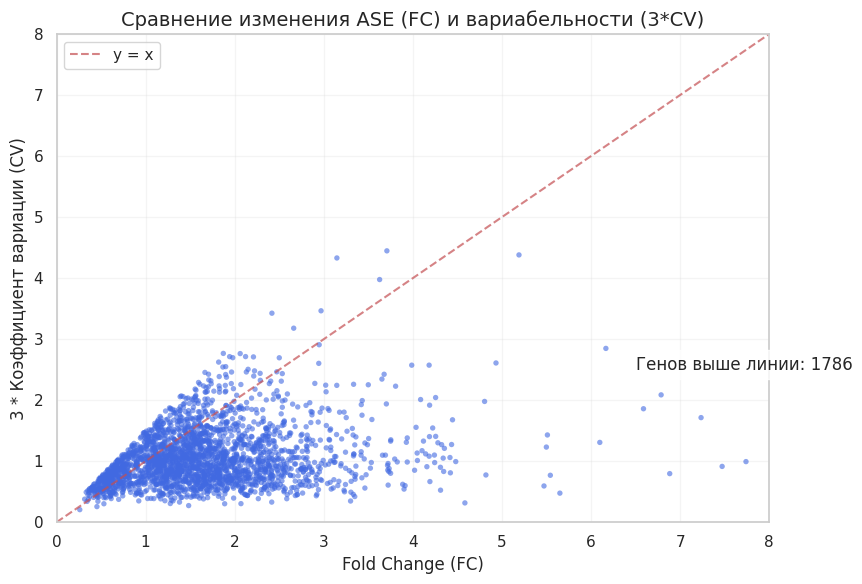

In [455]:
plt.figure(figsize=(8, 6))
plt.scatter(
    ress.FC,
    ress.CV * 3,
    s=15,  # Уменьшенный размер точек
    alpha=0.6,
    color='royalblue',
    edgecolor='none'
)

# Настройка осей
plt.xlim(0, 8)
plt.ylim(0, 8)

# Линия y=x для визуального сравнения
plt.plot([0, 8], [0, 8], 'r--', alpha=0.7, label='y = x')

plt.title('Сравнение изменения ASE (FC) и вариабельности (3*CV)', fontsize=14)
plt.xlabel('Fold Change (FC)', fontsize=12)
plt.ylabel('3 * Коэффициент вариации (CV)', fontsize=12)
plt.grid(alpha=0.2)
plt.legend()
plt.tight_layout()

# Добавляем аннотацию для генов выше линии
above_line = ress[ress.FC > ress.CV * 3]
plt.text(6.5, 2.5, f'Генов выше линии: {len(above_line)}',
         bbox=dict(facecolor='white', alpha=0.8))

plt.show()

/home/leon/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='std', ylabel='Density'>

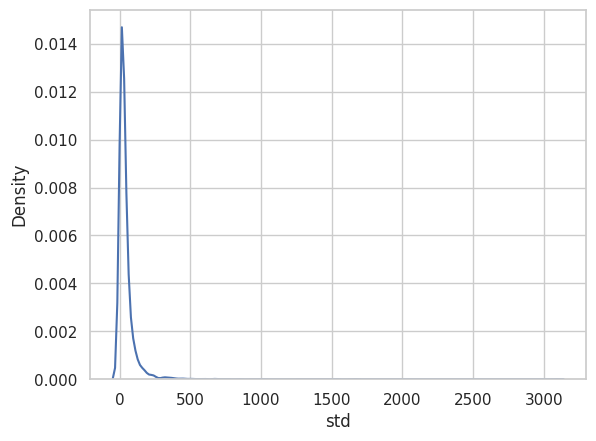

In [430]:
sns.kdeplot(res['std'])
# sns.kdeplot(ress['std'])

In [432]:
res.variance.apply('median') / ress.variance.apply('median')

1.9972569916355651

In [359]:
# все SNP с diffASE in vivo и in vitro хотя бы у одного человека
ase_vv = pd.read_csv("/media/leon/DISK2/icig/done/ase_snps.csv")
ase_vtr = pd.read_csv("/media/leon/DISK2/icig/done/ase_vtr_snps.csv")

# вычисляем изменение асимметрии
ase_vv["FC"] = ((ase_vv.DP_1R * ase_vv.QS_ref_1R) / (ase_vv.DP_1R * ase_vv.QS_alt1_1R)) / ((ase_vv.DP_0R * ase_vv.QS_ref_0R) / (ase_vv.DP_0R * ase_vv.QS_alt1_0R))
ase_vtr["FC"] = ((ase_vtr.DP_1R * ase_vtr.QS_ref_1R) / (ase_vtr.DP_1R * ase_vtr.QS_alt1_1R)) / ((ase_vtr.DP_0R * ase_vtr.QS_ref_0R) / (ase_vtr.DP_0R * ase_vtr.QS_alt1_0R))

# выбираем SNP с наибольшим покрытием для каждого гена (?)
ase_vv['dp_sum'] = ase_vv[['DP_0R', 'DP_1R', 'DP_30R', 'DP_90R']].fillna(0).sum(axis=1)
ase_vv = ase_vv.loc[ase_vv.groupby(['gene_id', 'id_sample_0R'])['dp_sum'].idxmax()]
ase_vtr['dp_sum'] = ase_vtr[['DP_0R', 'DP_1R']].fillna(0).sum(axis=1)
ase_vtr = ase_vtr.loc[ase_vtr.groupby(['gene_id', 'id_sample_0R'])['dp_sum'].idxmax()]

# усредняем FC, если ген встречается у нескольких людей
ase_vv_mean = ase_vv.groupby('gene_id', as_index=False)[['FC']].mean()
ase_vtr_mean = ase_vtr.groupby('gene_id', as_index=False)['FC'].mean()
combined = pd.concat([ase_vv_mean, ase_vtr_mean], ignore_index=True)
result = combined.groupby('gene_id', as_index=False).agg({'FC': 'mean'})
result["FC"]

0       1.620449
1       1.880039
2       1.242572
3       1.136639
4       2.299547
          ...   
5083    0.879265
5084    1.808522
5085    2.088432
5086    2.088432
5087    2.437331
Name: FC, Length: 5088, dtype: float64

In [293]:
res["triple_std"] = res.variance.apply(lambda x: 3 * x ** 0.5)
res["CV"] = res.triple_std / res.baseMean
gene_std_dct = dict(zip(disp.entrez, disp.CV))
gene_std_dct

{'148398': 0.04305205325383798,
 '26155': 0.08654056842824537,
 '339451': 7.955961227448409e-05,
 '375790': 0.6471642343362385,
 '54991': 1.3194303163392637e-05,
 '51150': 0.059612681182093376,
 '126792': 0.5449988959037043,
 '118424': 0.06175495967059351,
 '116983': 0.03935264731873142,
 '54973': 0.10918533811531993,
 '1855': 3.819867886642515e-05,
 '54998': 0.3055722822845919,
 '81669': 0.01501155673608872,
 '55052': 0.06357706565057239,
 '441869': 4.4074733132186116e-05,
 '64856': 0.15061195910012815,
 '219293': 0.0845138739746264,
 '83858': 0.0720469990504937,
 '55210': 3.8262405730438186e-05,
 '29101': 0.027872676520244537,
 '142678': 0.12422317920607019,
 '984': 0.038601432888112464,
 '728661': 0.03430717912393257,
 '65220': 0.054273077852704486,
 '2782': 0.002734571665673797,
 '5590': 1.2680712317594326e-05,
 '199990': 0.10018125942575896,
 '6497': 0.01290102154659235,
 '79906': 0.06179596311799568,
 '11079': 0.03430730850678698,
 '5192': 3.805583321545953e-05,
 '9651': 0.320664

In [340]:
len(set(disp.entrez).intersection(all_genes_pbmc))

3693

In [343]:
len(all_genes_pbmc)
len(result.entrez)

4042

In [345]:
result.entrez

0              16
1              18
2              20
3              25
5              29
          ...    
5081    127882475
5082    128125822
5083    128193293
5084    128385376
5087    131696449
Name: entrez, Length: 4042, dtype: object

In [295]:
result.gene_id = result.gene_id.apply(str)
result["CV"] = result.gene_id.map(gene_std_dct)
result = result[result.CV < abs(result.FC)]
result

,gene_id,FC,CV
1,18,1.178519,0.008561
2,20,1.242572,0.037553
3,25,1.136639,0.002427
5,29,1.008351,0.010360
6,30,0.730848,0.077305
...,...,...,...
4888,100529239,1.963414,0.162449
4893,100533464,0.395606,0.001059
4897,100534593,0.416393,0.048987
4913,101060200,0.411374,0.027243


/home/leon/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='FC', ylabel='Count'>

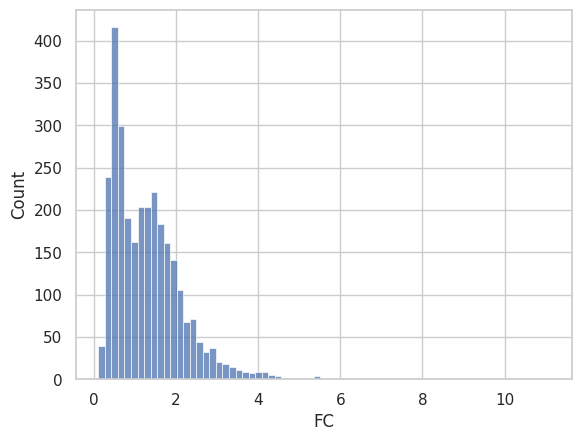

In [296]:
sns.histplot(result.FC)

/home/leon/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='CV', ylabel='Count'>

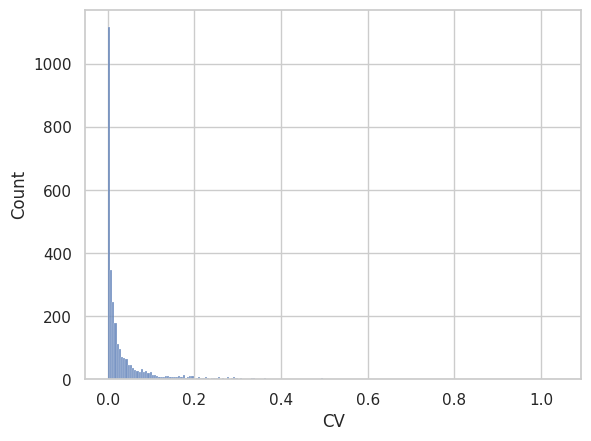

In [297]:
sns.histplot(result.CV)

In [234]:
# 3 * sqrt(fitted variance) 
gene_std_dct = dict(zip(disp.gene_id, [3 * i ** 0.5 for i in disp.dispMAP]))

# все SNP с diffASE in vivo и in vitro хотя бы у одного человека
ase_vv = pd.read_csv("/media/leon/DISK2/icig/done/ase_snps.csv")
ase_vtr = pd.read_csv("/media/leon/DISK2/icig/done/ase_vtr_snps.csv")

# вычисляем изменение асимметрии
ase_vv["FC"] = ((ase_vv.DP_1R * ase_vv.QS_ref_1R) / (ase_vv.DP_1R * ase_vv.QS_alt1_1R)) / ((ase_vv.DP_0R * ase_vv.QS_ref_0R) / (ase_vv.DP_0R * ase_vv.QS_alt1_0R))
ase_vtr["FC"] = ((ase_vtr.DP_1R * ase_vtr.QS_ref_1R) / (ase_vtr.DP_1R * ase_vtr.QS_alt1_1R)) / ((ase_vtr.DP_0R * ase_vtr.QS_ref_0R) / (ase_vtr.DP_0R * ase_vtr.QS_alt1_0R))

# выбираем SNP с наибольшим покрытием
ase_vv['dp_sum'] = ase_vv[['DP_0R', 'DP_1R', 'DP_30R', 'DP_90R']].fillna(0).sum(axis=1)
ase_vv = ase_vv.loc[ase_vv.groupby(['gene_id', 'id_sample_0R'])['dp_sum'].idxmax()]
ase_vtr['dp_sum'] = ase_vtr[['DP_0R', 'DP_1R']].fillna(0).sum(axis=1)
ase_vtr = ase_vtr.loc[ase_vtr.groupby(['gene_id', 'id_sample_0R'])['dp_sum'].idxmax()]

# усредняем FC, если ген встречается у нескольких людей
ase_vv_mean = ase_vv.groupby('gene_id', as_index=False)[['FC']].mean()
ase_vtr_mean = ase_vtr.groupby('gene_id', as_index=False)['log2FC1'].mean()
combined = pd.concat([ase_vv_mean, ase_vtr_mean], ignore_index=True)
result = combined.groupby('gene_id', as_index=False).agg({'FC': 'mean'})

# сравниваем 3*std с FC
result["triple_std"] = result.gene_id.map(gene_std_dct)
result = result[result.triple_std < abs(result.FC)]
result.gene_id # 1989 генов

,gene,baseMean,dispGeneEst,dispFit,dispMAP,isUniform,entrez
8,SAMD11,57.890292,6.901710e-01,0.158578,0.643325,False,148398
9,NOC2L,19.203802,3.068820e-01,0.246932,0.302584,True,26155
10,KLHL17,3.770757,1.000000e-08,0.788052,0.523273,False,339451
11,AGRN,3.980514,7.373349e-01,0.752570,0.738638,False,375790
12,C1orf159,22.737086,1.000000e-08,0.226386,0.097465,False,54991
...,...,...,...,...,...,...,...
13841,MT-ND4L,35.687100,1.348515e+00,0.185865,1.249054,False,4539
13842,MT-ND4,253.049385,1.219717e+00,0.124753,1.132236,False,4538
13843,MT-ND5,94.478634,7.977681e-01,0.141593,0.749401,False,4540
13844,MT-ND6,7.313620,4.782562e-01,0.461876,0.477204,False,4541


In [299]:
result.gene_id.to_csv("/media/leon/DISK2/icig/done/30.05.25.idkatthispoint.txt", index=False)

In [227]:
ase_vv = pd.read_csv("/media/leon/DISK2/icig/done/ase_snps.csv")
ase_vtr = pd.read_csv("/media/leon/DISK2/icig/done/ase_vtr_snps.csv")

In [228]:
ase_vv["log2FC1"] = ((ase_vv.DP_1R * ase_vv.QS_ref_1R) / (ase_vv.DP_1R * ase_vv.QS_alt1_1R)) / ((ase_vv.DP_0R * ase_vv.QS_ref_0R) / (ase_vv.DP_0R * ase_vv.QS_alt1_0R))
ase_vv["log2FC30"] = ((ase_vv.DP_30R * ase_vv.QS_ref_30R) / (ase_vv.DP_30R * ase_vv.QS_alt1_30R)) / ((ase_vv.DP_0R * ase_vv.QS_ref_0R) / (ase_vv.DP_0R * ase_vv.QS_alt1_0R))
ase_vv["log2FC90"] = ((ase_vv.DP_90R * ase_vv.QS_ref_90R) / (ase_vv.DP_90R * ase_vv.QS_alt1_90R)) / ((ase_vv.DP_0R * ase_vv.QS_ref_0R) / (ase_vv.DP_0R * ase_vv.QS_alt1_0R))
ase_vtr["log2FC1"] = ((ase_vtr.DP_1R * ase_vtr.QS_ref_1R) / (ase_vtr.DP_1R * ase_vtr.QS_alt1_1R)) / ((ase_vtr.DP_0R * ase_vtr.QS_ref_0R) / (ase_vtr.DP_0R * ase_vtr.QS_alt1_0R))
ase_vv

,gene_id,chr,pos,id_sample_0R,DP_0R,ref_0R,QS_ref_0R,alt1_0R,QS_alt1_0R,alt2_0R,...,p30,p90,p01adj,p30adj,p90adj,SYMBOL,GENENAME,log2FC1,log2FC30,log2FC90
0,10008,11,74455795,s1_0R,520,T,0.803962,C,0.191102,A,...,4.840993e-03,9.154205e-04,3.383877e-02,2.228194e-02,1.036133e-02,NaN,potassium voltage-gated channel subfamily E re...,1.773658,0.671548,1.737523
1,100132406,1,146069569,s1_0R,328,C,0.688695,T,0.311305,<*>,...,7.096891e-03,1.360050e-03,1.305141e-03,2.980876e-02,1.382814e-02,NaN,NBPF member 10,2.614111,1.695951,1.849795
2,100132406,1,146069630,s1_0R,635,G,0.631373,C,0.368627,<*>,...,1.197709e-10,2.368362e-13,6.801390e-10,1.006460e-08,5.352089e-11,NaN,NBPF member 10,3.319490,2.474733,2.879223
3,100132406,1,146069686,s1_0R,398,C,0.611598,T,0.388402,<*>,...,3.123458e-11,1.529818e-11,4.380467e-07,3.055628e-09,2.784907e-09,NaN,NBPF member 10,3.937374,3.567329,3.579125
4,100288778,12,16030,s1_0R,405,C,0.513955,T,0.486045,<*>,...,1.313413e-04,1.741008e-03,4.675246e-02,1.300417e-03,1.624156e-02,NaN,"WAS protein family homolog 8, pseudogene",1.512393,1.904425,1.640780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8552,9870,14,74713031,s15_0R,638,C,0.431837,G,0.568163,<*>,...,1.907226e-06,1.533570e-03,8.826274e-05,8.134345e-05,8.293257e-03,NaN,apoptosis resistant E3 ubiquitin protein ligase 1,1.765030,1.717732,1.458808
8553,9887,1,183517724,s15_0R,236,G,0.389767,A,0.605372,T,...,1.930177e-05,7.002407e-04,9.538389e-05,5.151870e-04,4.449565e-03,NaN,SMG7 nonsense mediated mRNA decay factor,2.282756,2.079883,1.826505
8554,9926,1,211745704,s15_0R,862,C,0.415274,T,0.583704,G,...,2.582739e-06,4.520122e-08,2.791207e-06,1.031517e-04,1.546472e-06,NaN,lysophosphatidylglycerol acyltransferase 1,1.663884,1.532121,1.670143
8555,9938,2,68826622,s15_0R,2619,C,0.570798,T,0.428724,A,...,2.211291e-06,1.509687e-02,3.527711e-02,9.191207e-05,4.950853e-02,NaN,Rho GTPase activating protein 25,0.857164,0.777470,0.868881


In [159]:
df_consistent.columns

Index(['patient', 'symbol', 'cell_type', 'assay_type', 'chr', 'pos', 'ref',
       'allele1', 'allele2', 'rsid', 'gene', 'regtype', 'cov_all1', 'cov_all2',
       'p.adj', 'p.value', 'log2FC'],
      dtype='object')

In [229]:
print(len(set(ase_vv.gene_id)))
print(len(set(ase_vtr.gene_id)))
print(len(set(ase_vv.gene_id).union(set(ase_vtr.gene_id))))

4042
2531
5088


In [230]:
ase_vv['dp_sum'] = ase_vv[['DP_0R', 'DP_1R', 'DP_30R', 'DP_90R']].fillna(0).sum(axis=1)
ase_vv = ase_vv.loc[ase_vv.groupby(['gene_id', 'id_sample_0R'])['dp_sum'].idxmax()]
ase_vtr['dp_sum'] = ase_vtr[['DP_0R', 'DP_1R']].fillna(0).sum(axis=1)
ase_vtr = ase_vtr.loc[ase_vtr.groupby(['gene_id', 'id_sample_0R'])['dp_sum'].idxmax()]
ase_vtr

,gene_id,chr,pos,id_sample_0R,DP_0R,ref_0R,QS_ref_0R,alt1_0R,QS_alt1_0R,alt2_0R,...,alt1_1R,QS_alt1_1R,alt2_1R,QS_alt2_1R,p01,p01adj,SYMBOL,GENENAME,log2FC1,dp_sum
338,18,16,8782835,RNASEQ_sAn_DR,103,C,0.383234,T,0.616766,<*>,...,T,0.384013,<*>,0.000000,0.001029,0.008653,ABAT,4-aminobutyrate aminotransferase,2.581559,205
2111,27,1,179100294,RNASEQ_sDm_DR,239,C,0.379808,T,0.620192,<*>,...,T,0.415239,<*>,0.000000,0.000025,0.000999,ABL2,"ABL proto-oncogene 2, non-receptor tyrosine ki...",2.299547,442
638,35,12,120737096,RNASEQ_sAn_DR,283,T,0.410515,C,0.589485,<*>,...,C,0.420265,<*>,0.000000,0.000045,0.000812,ACADS,acyl-CoA dehydrogenase short chain,1.980843,591
644,36,10,123055940,RNASEQ_sAn_DR,100,A,0.432273,C,0.567727,<*>,...,C,0.340652,<*>,0.000000,0.000428,0.004533,ACADSB,acyl-CoA dehydrogenase short/branched chain,2.542056,272
2173,36,10,123055878,RNASEQ_sDm_DR,116,G,0.673464,A,0.326536,<*>,...,A,0.603675,<*>,0.000000,0.000034,0.001278,ACADSB,acyl-CoA dehydrogenase short/branched chain,0.318321,246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2820,127739546,9,128820891,RNASEQ_sKh_DR,303,T,0.388755,C,0.611245,<*>,...,C,0.430164,<*>,0.000000,0.000034,0.000491,KYAT1-SPOUT1,KYAT1-SPOUT1 readthrough,2.082836,554
271,128193293,2,87455582,RNASEQ_sAn_DR,1162,C,0.529652,T,0.470348,<*>,...,T,0.548281,<*>,0.000000,0.000128,0.001806,NCAL1,NK cell activity associated lncRNA 1,0.731634,2495
1983,128966684,17,36196280,RNASEQ_sDm_DR,374,G,0.375020,C,0.624980,<*>,...,C,0.436208,A,0.017151,0.000002,0.000160,LOC128966684,uncharacterized LOC128966684,2.088432,703
1984,128966706,17,36196280,RNASEQ_sDm_DR,374,G,0.375020,C,0.624980,<*>,...,C,0.436208,A,0.017151,0.000002,0.000160,LOC128966706,uncharacterized LOC128966706,2.088432,703


In [231]:
ase_vv_mean = (
    ase_vv
    .groupby('gene_id', as_index=False)[['log2FC1', 'log2FC30', 'log2FC90']]
    .mean()
)
ase_vtr_mean = (
    ase_vtr
    .groupby('gene_id', as_index=False)['log2FC1']
    .mean()
)
ase_vtr_mean

,gene_id,log2FC1
0,18,2.581559
1,27,2.299547
2,35,1.980843
3,36,1.430189
4,51,2.523599
...,...,...
2526,127739546,2.082836
2527,128193293,0.731634
2528,128966684,2.088432
2529,128966706,2.088432


In [260]:
for col in ['log2FC30', 'log2FC90']:
    if col not in ase_vtr_mean.columns:
        ase_vtr_mean[col] = np.nan
combined = pd.concat([ase_vv_mean, ase_vtr_mean], ignore_index=True)
result = (
    combined
    .groupby('gene_id', as_index=False)
    .agg({
        'log2FC1': 'mean',
        'log2FC30': 'mean',
        'log2FC90': 'mean'
    })
)
result

,gene_id,log2FC1,log2FC30,log2FC90
0,16,1.620449,1.534593,2.153965
1,18,1.880039,1.740087,1.393920
2,20,1.242572,1.504305,1.537386
3,25,1.136639,0.896102,1.339422
4,27,2.299547,NaN,NaN
...,...,...,...,...
5083,128193293,0.879265,0.976872,1.160808
5084,128385376,1.808522,1.865193,1.862989
5085,128966684,2.088432,NaN,NaN
5086,128966706,2.088432,NaN,NaN


In [233]:
gene_lfc_dct = dict(zip(result.gene_id, result.log2FC1))
gene_lfc_dct

{16: 1.620449069502099,
 18: 1.8800390080510434,
 20: 1.2425724550266224,
 25: 1.1366394683129641,
 27: 2.29954713176012,
 29: 1.0083514028164946,
 30: 0.7308479852841329,
 35: 1.9808428644058156,
 36: 1.4301885995642187,
 37: 0.7037657337773312,
 38: 0.4550541821019781,
 39: 0.5608829881215888,
 47: 0.6676483061501794,
 50: 0.9169002468908207,
 51: 2.2862457096275213,
 52: 0.4685548757679345,
 53: 1.5656814136429769,
 54: 0.2548679344281805,
 55: 0.4974969524218254,
 71: 0.8905489555934565,
 81: 0.8122081278755331,
 87: 0.9827426106216042,
 90: 0.4698696096975457,
 91: 1.1595471951134195,
 101: 1.1239629804623807,
 103: 1.1606820778118876,
 113: 1.4375472498549715,
 115: 0.2956994771404082,
 118: 1.2756821145772523,
 123: 1.1394451264860925,
 135: 1.6909778606465697,
 142: 1.2492079775348273,
 143: 1.3327650168850003,
 154: 1.135604590731116,
 156: 0.3280817248631379,
 157: 1.160288271395685,
 161: 0.44992953111142286,
 162: 1.5887367400987988,
 163: 1.6234176729610907,
 164: 2.387204

In [156]:
print(len(set(df_filtered.gene)))
len(set(df_filtered.gene).intersection(set(ase_vv.gene_id).union(set(ase_vtr.gene_id))))

485


211

In [157]:
commonrsids = df_filtered[df_filtered.gene.isin(set(df_filtered.gene).intersection(set(ase_vv.gene_id).union(set(ase_vtr.gene_id))))]
variance_df = (
    commonrsids
    .groupby('rsid')['log2FC']
    .agg([
        ('log2FC_variance', 'var'),  # Мфкшфтсу
        ('log2FC_std', 'std')                   # Standard deviation
    ])
    .reset_index()
)
variance_df

,rsid,log2FC_variance,log2FC_std
0,rs1000386674,0.169648,0.411883
1,rs10068266,0.088831,0.298045
2,rs1011319058,0.312191,0.558741
3,rs1020019184,0.137208,0.370417
4,rs1022435976,0.251808,0.501805
...,...,...,...
451,rs9910708,0.002692,0.051880
452,rs991379843,0.136037,0.368832
453,rs994717960,0.213198,0.461734
454,rs997950901,0.095543,0.309100


In [168]:
gene_snp_dct = dict(zip(df_filtered.rsid, df_filtered.gene))
variance_df["gene"] = variance_df.rsid.map(gene_snp_dct)
variance_df["log2FC"] = variance_df.gene.map(gene_lfc_dct)
variance_df

,rsid,log2FC_variance,log2FC_std,gene,log2FC
0,rs1000386674,0.169648,0.411883,7690,-1.778254
1,rs10068266,0.088831,0.298045,3659,-0.573441
2,rs1011319058,0.312191,0.558741,9907,0.619942
3,rs1020019184,0.137208,0.370417,2778,-1.576483
4,rs1022435976,0.251808,0.501805,79786,-0.175242
...,...,...,...,...,...
451,rs9910708,0.002692,0.051880,84440,0.073332
452,rs991379843,0.136037,0.368832,10135,0.319573
453,rs994717960,0.213198,0.461734,29035,0.949522
454,rs997950901,0.095543,0.309100,6711,-0.998164


In [170]:
res_df = variance_df[variance_df.log2FC_std * 2 < abs(variance_df.log2FC)]
res_df

,rsid,log2FC_variance,log2FC_std,gene,log2FC
0,rs1000386674,0.169648,0.411883,7690,-1.778254
3,rs1020019184,0.137208,0.370417,2778,-1.576483
12,rs1043990,0.001030,0.032088,84440,0.073332
16,rs1058596,0.157511,0.396877,5264,-1.595197
17,rs10802570,0.250808,0.500808,4548,-2.274162
...,...,...,...,...,...
438,rs944861075,0.117913,0.343385,4054,1.132225
447,rs978932095,0.331452,0.575719,154881,1.309821
449,rs9882859,0.105239,0.324406,201626,1.208744
453,rs994717960,0.213198,0.461734,29035,0.949522


In [174]:
res_df.gene.to_csv("/media/leon/DISK2/icig/done/30.05.25.listofuniformgenes.txt", index=False)

In [20]:
bulk_df = pd.read_csv("/media/leon/Masha/ATAC/results/SNP_reg_NEWer.csv", index_col=0)
bulk_df

,patient,symbol,assay_type,chr,pos,ref,allele1,allele2,rsid,gene,regtype,cov_all1,cov_all2,p.adj,p.value,log2FC
2,MM108,AATK,mmATAC,17,81122012,G,G,A,rs746338931,9625,promoter,35.584832,7.415168,1.539215e-04,8.963039e-06,2.262711
13,MM108,AATK,mmATAC,17,81125788,T,T,C,rs4969252,9625,promoter,6.708314,21.347264,6.630032e-02,1.254095e-02,-1.670029
22,MM108,AATK,mmATAC,17,81126174,G,G,C,rs117628515,9625,promoter,4.766570,18.233430,5.865385e-02,1.062202e-02,-1.935563
30,MM108,AATK,mmATAC,17,81119753,C,C,T,rs148226642,9625,promoter,345.140459,99.658023,1.534822e-30,1.313194e-32,1.792126
31,MM108,ABL1,mmATAC,9,130834859,A,A,T,rs2987902,25,promoter,89.656038,130.545815,4.283083e-02,6.994729e-03,-0.542084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114996,MM98,ZSCAN31,mmATAC,6,28354343,C,C,G,rs6903652,64288,promoter,48.289752,15.689877,1.056872e-03,7.733077e-05,1.621883
114997,MM98,ZSCAN31,ATAC,6,28354343,C,C,G,rs6903652,64288,promoter,29.739142,9.495880,9.752588e-03,1.065020e-03,1.646989
115002,MM98,ZZZ3,mmATAC,1,77683257,C,C,T,rs149557970,26009,promoter,340.806024,271.340742,3.441905e-02,5.242450e-03,0.328845
115003,MM98,ZZZ3,mmATAC,1,77683111,C,C,T,rs202031353,26009,promoter,195.355755,75.093552,7.482643e-12,1.757338e-13,1.379343


In [9]:
r17 = pd.read_csv("/media/leon/DISK2/icig/sc/r17.csv", index_col=0)
r17

,pos,gene_id,id_sample_0C,DP_0C,ref_0C,QS_ref_0C,alt1_0C,QS_alt1_0C,alt2_0C,QS_alt2_0C,...,QS_alt2_1C,p01,p01adj,SYMBOL,GENENAME,log2FCB,rsid,variant_id,log2FC_1,log2FC_0
chr,,,,,,,,,,,,,,,,,,,,,
1,112674689,4343,s1_0C,879,G,0.430281,C,0.569320,A,0.000399,...,0.002140,2.363209e-03,2.205227e-02,NaN,Mov10 RNA helicase,0.478118,rs3748655,1_112674689_G_C,-0.074158,0.403961
12,1690902,79602,s1_0C,516,G,0.593276,C,0.406724,<*>,0.000000,...,0.000000,4.360222e-03,3.367232e-02,NaN,adiponectin receptor 2,-0.666801,rs115457226,12_1690902_G_C,0.122148,-0.544653
13,24251913,221178,s1_0C,478,C,0.525168,T,0.474832,<*>,0.000000,...,0.000000,2.932087e-03,2.550128e-02,NaN,spermatogenesis associated 13,0.702911,rs2793491,13_24251913_C_T,-0.848273,-0.145362
14,22918400,55147,s1_0C,1455,T,0.544905,A,0.429922,G,0.025173,...,0.019988,3.041495e-03,2.622816e-02,NaN,RNA binding motif protein 23,0.456795,rs55898715,14_22918400_T_A,-0.798725,-0.341930
14,92659070,79890,s1_0C,173,G,0.553424,C,0.446576,<*>,0.000000,...,0.000000,8.758760e-05,2.168897e-03,NaN,Ras and Rab interactor 3,-1.479996,rs2295991,14_92659070_G_C,1.170516,-0.309479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9,130043535,23048,s7_0C,114,T,0.153209,G,0.846791,<*>,0.000000,...,0.000000,3.975197e-12,9.889207e-10,NaN,formin binding protein 1,2.703587,rs7037717,9_130043535_T_G,-0.237082,2.466505
9,134135347,11091,s7_0C,166,G,0.641174,C,0.358826,<*>,0.000000,...,0.000000,2.993296e-04,2.121054e-03,NaN,WD repeat domain 5,-1.001307,rs28580780,9_134135347_G_C,0.163876,-0.837431
9,2016470,6595,s7_0C,257,G,0.635031,A,0.364969,<*>,0.000000,...,0.000564,1.606820e-08,6.924510e-07,NaN,SWI/SNF related BAF chromatin remodeling compl...,-1.243924,rs193151798,9_2016470_G_A,0.444871,-0.799053


In [21]:
df = pd.read_csv("/media/leon/Masha/ATAC/results/sc_SNP_reg_NEWer.csv", index_col=0)
# df = pd.read_csv("/media/leon/DISK2/icig/sc/SNP_sc_only.csv", index_col=0)
df

,patient,symbol,cell_type,assay_type,chr,pos,ref,allele1,allele2,rsid,gene,regtype,cov_all1,cov_all2,p.adj,p.value,log2FC
3,MM108,ARVCF,alpha,mmATAC,22,19987331,A,A,C,rs1227885166,421,promoter,29.467040,10.112916,2.297082e-02,3.377848e-03,1.542903
4,MM108,ARVCF,alpha,mmATAC,22,20016788,C,C,T,rs2286480,421,promoter,22.973075,60.793942,5.927437e-04,4.077127e-05,-1.403984
5,MM108,ARVCF,alpha,mmATAC,22,19987333,A,A,C,rs1943847533,421,promoter,31.055558,7.456715,1.453930e-03,1.161670e-04,2.058239
8,MM108,ARVCF,alpha,mmATAC,22,19987332,G,G,C,rs1161363724,421,promoter,31.538739,9.089619,4.448106e-03,4.308570e-04,1.794833
15,MM108,GNAS,alpha,mmATAC,20,58888801,C,C,G,rs1279918127,2778,promoter,19.309861,5.699953,7.111589e-02,1.463330e-02,1.760316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41014,MM98,ZNF84,alpha,mmATAC,12,133037682,T,T,G,rs1316804643,7637,promoter,102.799680,21.363171,2.254883e-12,3.495517e-14,2.266638
41016,MM98,ZNF84,beta,mmATAC,12,133037672,T,T,G,rs1220676491,7637,promoter,275.106557,50.242725,5.628281e-36,8.642643e-39,2.453004
41018,MM98,ZNF84,beta,ATAC,12,133037682,T,T,G,rs1316804643,7637,promoter,44.542260,24.273522,7.425479e-02,1.543230e-02,0.875791
41020,MM98,ZNF84,beta,mmATAC,12,133037677,C,C,G,rs1593689528,7637,promoter,185.730050,99.600039,9.545550e-06,4.129805e-07,0.898989


In [22]:
[bulk_df.rsid.nunique(), df.rsid.nunique()]

[14386, 3829]

In [23]:
bulk_rsids = set(bulk_df.rsid)
sc_rsids = set(df.rsid)
sc_only_rsids = sc_rsids - bulk_rsids
print(len(bulk_rsids), len(sc_rsids), len(sc_only_rsids))

14386 3829 1928


In [24]:
all_rsids = bulk_rsids.union(sc_rsids)
len(all_rsids)

16314

In [10]:
len(set(r17.rsid))

236

In [11]:
len(all_rsids.intersection(set(r17.rsid)))

32

In [32]:
all_genes = list(bulk_df.gene)
all_genes.extend(list(df.gene))
len(set(all_genes))

3090

In [109]:
len(set(r17.gene_id))

181

In [13]:
len(set(all_genes).intersection(set(r17.gene_id)))

56

In [33]:
df.groupby(["cell_type"])["rsid"].nunique()
# sc_df.groupby(["cell_type"])["rsid"].nunique()

cell_type
EC             1
acinar        41
alpha       2134
beta        2561
delta        527
ductal        12
gamma        114
immune         8
stellate       1
Name: rsid, dtype: int64

In [34]:
ct_counts = df.groupby("rsid")["cell_type"].nunique()
# ct_counts = sc_df.groupby("rsid")["cell_type"].nunique()
ct_distribution = ct_counts.value_counts().sort_index()
ct_distribution

cell_type
1    2599
2     945
3     243
4      32
5       8
6       1
7       1
Name: count, dtype: int64

In [35]:
def check_sign(logfcs):
    return (logfcs > 0).all() or (logfcs < 0).all()

same_sign_rsids = df.groupby("rsid")["log2FC"].apply(check_sign)
# same_sign_rsids = sc_df.groupby("rsid")["log2FC"].apply(check_sign)
same_sign_rsids = same_sign_rsids[same_sign_rsids].index
df_consistent = df[df["rsid"].isin(same_sign_rsids)]
# df_consistent = sc_df[sc_df["rsid"].isin(same_sign_rsids)]
df_consistent

,patient,symbol,cell_type,assay_type,chr,pos,ref,allele1,allele2,rsid,gene,regtype,cov_all1,cov_all2,p.adj,p.value,log2FC
3,MM108,ARVCF,alpha,mmATAC,22,19987331,A,A,C,rs1227885166,421,promoter,29.467040,10.112916,2.297082e-02,3.377848e-03,1.542903
4,MM108,ARVCF,alpha,mmATAC,22,20016788,C,C,T,rs2286480,421,promoter,22.973075,60.793942,5.927437e-04,4.077127e-05,-1.403984
5,MM108,ARVCF,alpha,mmATAC,22,19987333,A,A,C,rs1943847533,421,promoter,31.055558,7.456715,1.453930e-03,1.161670e-04,2.058239
8,MM108,ARVCF,alpha,mmATAC,22,19987332,G,G,C,rs1161363724,421,promoter,31.538739,9.089619,4.448106e-03,4.308570e-04,1.794833
15,MM108,GNAS,alpha,mmATAC,20,58888801,C,C,G,rs1279918127,2778,promoter,19.309861,5.699953,7.111589e-02,1.463330e-02,1.760316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41014,MM98,ZNF84,alpha,mmATAC,12,133037682,T,T,G,rs1316804643,7637,promoter,102.799680,21.363171,2.254883e-12,3.495517e-14,2.266638
41016,MM98,ZNF84,beta,mmATAC,12,133037672,T,T,G,rs1220676491,7637,promoter,275.106557,50.242725,5.628281e-36,8.642643e-39,2.453004
41018,MM98,ZNF84,beta,ATAC,12,133037682,T,T,G,rs1316804643,7637,promoter,44.542260,24.273522,7.425479e-02,1.543230e-02,0.875791
41020,MM98,ZNF84,beta,mmATAC,12,133037677,C,C,G,rs1593689528,7637,promoter,185.730050,99.600039,9.545550e-06,4.129805e-07,0.898989


In [36]:
print(df.log2FC.mean())
print(df_consistent.log2FC.mean())

0.5887423604574948
0.690806708236105


In [37]:
df_consistent.groupby(["cell_type"])["rsid"].nunique()

cell_type
EC           1
acinar      26
alpha     1870
beta      2291
delta      397
ductal       3
gamma       82
Name: rsid, dtype: int64

In [38]:
all_rsids = list(bulk_df.rsid)
all_rsids.extend(list(df_consistent.rsid))
len(set(all_rsids))

16148

In [39]:
cons_ct_counts = df_consistent.groupby("rsid")["cell_type"].nunique()
cons_ct_distribution = cons_ct_counts.value_counts().sort_index()
cons_ct_distribution

cell_type
1    2546
2     717
3     193
4      24
5       3
Name: count, dtype: int64

In [40]:
ct_distribution

cell_type
1    2599
2     945
3     243
4      32
5       8
6       1
7       1
Name: count, dtype: int64

In [41]:
plot_df = cons_ct_distribution.reset_index()
plot_df.columns = ["n_cell_types", "n_rsids"]
plot_df

,n_cell_types,n_rsids
0,1,2546
1,2,717
2,3,193
3,4,24
4,5,3


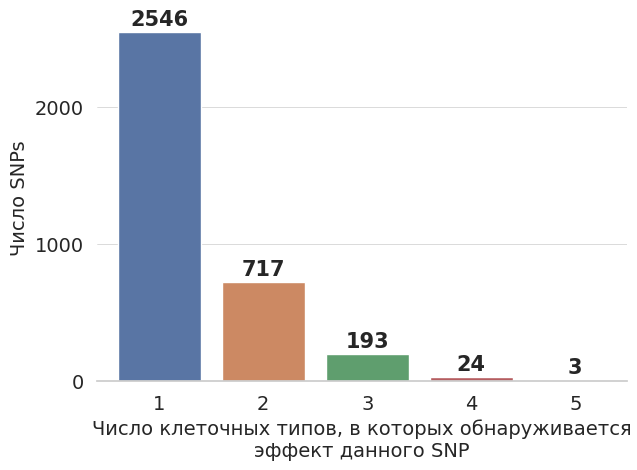

In [54]:
sns.set_theme(style="whitegrid")

ax = sns.barplot(data=plot_df, x="n_cell_types", y="n_rsids",  width=0.8)
for patch in ax.patches:
    x = patch.get_x() + patch.get_width() / 2
    y = patch.get_height()
    ax.text(x, y + 20, f"{int(y)}", ha='center', va='bottom', fontweight='bold', fontsize = 15)

max_y = plot_df["n_rsids"].max()
# ax.set_ylim(0, max_y + 1500)
ax.set_xlabel("Число клеточных типов, в которых обнаруживается\nэффект данного SNP", fontsize = 14)
ax.set_ylabel("Число SNPs", fontsize = 14)
ax.set_yticks(range(0, 3000, 1000))
ax.grid(True, which='major', axis='y', linewidth=0.5, color='gray', alpha=0.4)
ax.set_xlim(-0.6, 4.5)
plt.tight_layout(pad=1.0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig("/media/leon/Masha/figures/ct_distribution.png", dpi=600)
plt.show()

In [153]:
set(df_consistent.symbol)

{'MACC1-OT1',
 'CD151',
 'NDUFA5',
 'LOC101929004',
 'LOC124904620',
 'GARIN1A',
 'ARL4A',
 'NAXD',
 'DLEU2',
 'LINC00673',
 'ATP9A',
 'CMTR2',
 'LINC01927',
 'L2HGDH',
 'ZNF540',
 'PPHLN1',
 'RAB11A',
 'RHOBTB3',
 'OPA3',
 'COPS7B',
 'TMX1',
 'ETV5',
 'PRKAG2-AS1',
 'SLC16A9',
 'ATG2A',
 'NEDD4L',
 'CD81',
 'TAF1C',
 'LOC105372310',
 'MTR',
 'SSR3',
 'LOC124903214',
 'SLC20A2',
 'DDX42',
 'LOC284600',
 'FNIP2',
 'GPATCH2L',
 'PCNA',
 'CD2BP2-DT',
 'FBRSL1',
 'IRS2',
 'H1-10',
 'EFTUD2',
 'MIR3671',
 'TRAK1',
 'GJD2-DT',
 'ERICH1',
 'LOC105371592',
 'MCMDC2',
 'LOC105375521',
 'SOCS2',
 'CD46',
 'PIP4P1',
 'ASB3',
 'EIF3J-DT',
 'FBRS',
 'ATP2A3',
 'HADH',
 'DCBLD2',
 'JPT2',
 'SETX',
 'CEP350',
 'GNPNAT1',
 'ZNF318',
 'AASDHPPT',
 'AP1S3',
 'LZTR1',
 'TNPO2',
 'FOXP1',
 'KIF1B',
 'MAF1',
 'HNRNPK',
 'DYM',
 'ZDHHC14',
 'TSEN2',
 'MAGI1',
 'SORBS1',
 'RAB3IP',
 'ENO4',
 'CDK13',
 'BAZ2B',
 'HDHD3',
 'MYH10',
 'ATAD3B',
 'G3BP1',
 'HNRNPD',
 'CCDC50',
 'FOCAD',
 'NCL',
 'LMAN2',
 'STAT1'

In [ ]:
# plot_df = ct_distribution.reset_index()
# plot_df.columns = ["n_cell_types", "n_rsids"]

# sns.set_theme(style="whitegrid")

# ax = sns.barplot(data=plot_df, x="n_cell_types", y="n_rsids")
# for patch in ax.patches:
#     x = patch.get_x() + patch.get_width() / 2
#     y = patch.get_height()
#     ax.text(x, y + 20, f"{int(y)}", ha='center', va='bottom', fontweight='bold')

# max_y = plot_df["n_rsids"].max()
# ax.set_ylim(0, max_y + 1000)
# ax.set_xlabel("Число типов клеток, в которых проявляется данный rSNP")
# ax.set_ylabel("Число rSNPs")
# plt.show()

In [174]:
print(df_consistent.head())

   chr        pos              sample        rsid ref allele1 allele2  \
1    1  100132743    SRR18593412_beta  rs11166405   A       A       G   
2    1  100132883    SRR18593357_beta  rs55863167   G       G       C   
3    1  100249898    SRR18593359_beta   rs3806235   G       G       A   
4    1  100249898  SRR14048772_acinar   rs3806235   G       G       A   
5    1  100249898   SRR14048757_alpha   rs3806235   G       G       A   

     cov_all1   cov_all2 minor_allele       gene    symbol   regtype  \
1    1.405064  19.594932            G     163786     SASS6  promoter   
2    3.146018  32.853996            C     163786     SASS6  promoter   
3   36.774580  16.431325          NaN  100506007  RTCA-AS1  promoter   
4   62.724135  22.299495          NaN  100506007  RTCA-AS1  promoter   
5  115.410582  73.828692          NaN  100506007  RTCA-AS1  promoter   

        p.value     p.adj    log2FC cell_type       variant_id    sample_id  \
1  2.098083e-05  0.001147 -3.801773      beta  1_

In [32]:
from scipy import stats

In [250]:
np.var

<function var at 0x7f9ca00992f0>

In [96]:
df_filtered.log2FC.min()

-3.15042987070035

In [92]:
def mean_pairwise_difference(series):
    values = series.tolist()  # Convert Series to list
    total = 0.0
    c = 0
    n = len(values)

    for i in range(n):
        for j in range(i+1, n):
            total += abs(values[i] - values[j])
            c += 1
    return total / c if c > 0 else 0.0

# mean_pairwise_difference(5)

In [99]:
rsid_counts = df_consistent.groupby('rsid')['cell_type'].nunique()
valid_rsids = rsid_counts[rsid_counts >= 2].index
df_filtered = df_consistent[df_consistent['rsid'].isin(valid_rsids)]

variance_df = (
    df_filtered
    .groupby('rsid')['log2FC']
    .agg([
        ('log2FC_variance', 'var'),  # Мфкшфтсу
        ('log2FC_std', 'std'),                   # Standard deviation
        ('mean_delta_log2FC', mean_pairwise_difference)  # Mean pairwise abs difference
    ])
    .reset_index()
    .sort_values('mean_delta_log2FC', ascending=False)
)
variance_df

,rsid,log2FC_variance,log2FC_std,mean_delta_log2FC
551,rs2290656,2.581578e+00,1.606729,2.272258
842,rs841229,2.278784e+00,1.509564,2.134846
718,rs60026475,2.043260e+00,1.429426,2.021514
702,rs56154935,1.954321e+00,1.397970,1.977028
214,rs12885713,1.809484e+00,1.345171,1.902359
...,...,...,...,...
408,rs16856991,2.655110e-05,0.005153,0.007287
376,rs1584033324,1.642674e-05,0.004053,0.004680
550,rs2281824,7.923905e-06,0.002815,0.003981
219,rs1291717897,5.665840e-06,0.002380,0.003366


In [98]:
filt_df = variance_df[variance_df.log2FC_std * 2 < variance_df.mean_delta_log2FC]
filt_df

,rsid,log2FC_variance,log2FC_std,mean_delta_log2FC
850,rs867137127,0.918247,0.958252,2.588688
135,rs1189563480,0.368905,0.607375,2.409524
75,rs113496080,1.194168,1.092780,2.344258
556,rs2301669,1.163934,1.078858,2.305037
238,rs1316804643,0.429893,0.655663,2.188569
...,...,...,...,...
461,rs186861152,0.017601,0.132670,0.279382
341,rs1467199528,0.013383,0.115686,0.262629
390,rs1594804739,0.011948,0.109309,0.254643
510,rs2051390774,0.009506,0.097501,0.226531


/home/leon/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_2833/2593553460.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


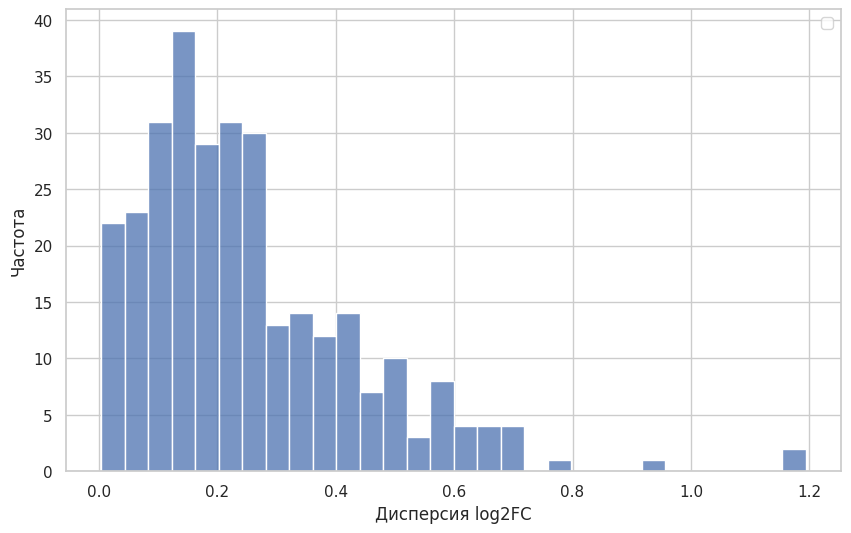

In [62]:
plt.figure(figsize=(10, 6))
sns.histplot(
    data=filt_df,
    x='log2FC_variance',
    bins=30  # Adjust based on your data range
    # kde=True,  # Add kernel density estimate
 
)
# plt.axvline(
#     variance_df['log2FC_variance'].median(),
#     color='red',
#     linestyle='--',
#     label=f'Median = {variance_df["log2FC_variance"].median():.2f}'
# )
# plt.title('Distribution of log2FC Variances Across rsids')
plt.xlabel('Дисперсия log2FC')
plt.ylabel('Частота')
plt.legend()
plt.show()

/tmp/ipykernel_2833/2896922380.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cv_df = cv_df[rsid_counts >= 2]
/home/leon/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_2833/2896922380.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


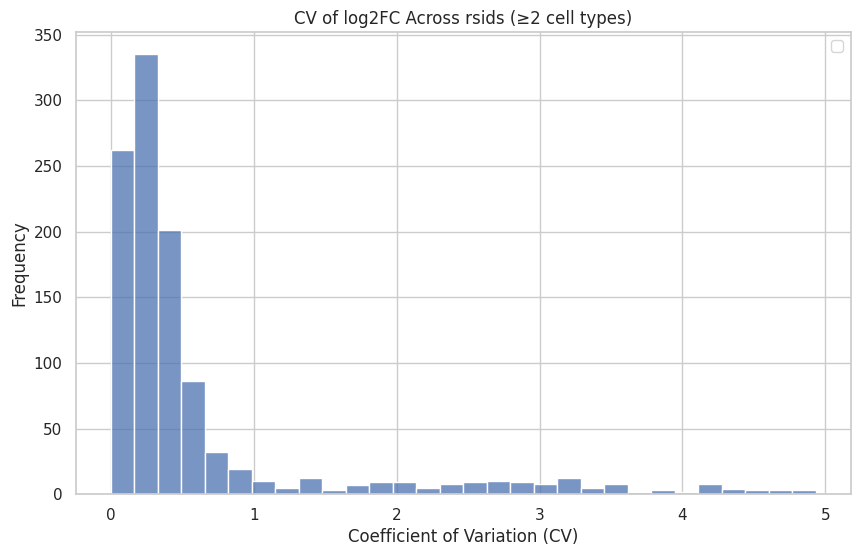

In [44]:
import numpy as np

def coefficient_of_variation(group):
    mean = group.mean()
    std = group.std()
    if np.isclose(mean, 0):  # Handle near-zero means
        return np.nan
    return std / abs(mean)  # Use absolute mean to avoid negative CVs

cv_df = df.groupby('rsid')['log2FC'].agg(
    mean_log2FC='mean',
    std_log2FC='std',
    cv=coefficient_of_variation
).dropna().sort_values('cv', ascending=False)

rsid_counts = df.groupby('rsid')['cell_type'].nunique()
cv_df = cv_df[rsid_counts >= 2]
cv_df = cv_df[cv_df.cv < 5]
plt.figure(figsize=(10, 6))
sns.histplot(cv_df['cv'], bins=30)
# plt.axvline(cv_df['cv'].median(), color='red', linestyle='--', label='Median CV')
plt.xlabel('Coefficient of Variation (CV)')
plt.ylabel('Frequency')
# plt.xlim(0, 5000)

plt.title('CV of log2FC Across rsids (≥2 cell types)')
plt.legend()

plt.show()

In [259]:
cv_df

,mean_log2FC,std_log2FC,cv
rsid,,,
rs13882,0.000020,1.319215,66115.090379
rs115578731,-0.000479,2.372191,4955.939429
rs1128030,-0.001645,4.420379,2687.052254
rs181686511,0.001427,3.141709,2201.333240
rs1916,0.001253,2.563845,2045.487431
...,...,...,...
rs6084506,2.909668,0.000608,0.000209
rs7011185,3.002719,0.000350,0.000117
rs701726,-2.278867,0.000209,0.000092


In [208]:
cv_df.describe()

,mean_log2FC,std_log2FC,cv
count,9039.000000,9039.000000,9039.000000
mean,0.899973,1.326952,14.854202
std,1.893720,0.962844,700.210938
min,-8.127960,0.000000,0.000000
25%,-0.516706,0.660979,0.274269
50%,0.994833,1.030077,0.463559
75%,2.569749,1.810561,2.542818
max,7.364874,6.471789,66115.090379


In [3]:
df = pd.read_csv("/media/leon/Masha/ananastra/ananastra_mabel_xujrs6pf.all.tsv", sep='\t')
df = df[df.asb_status == "ASB"]
df

,snp_id,asb_status,tf_asb_status,cl_asb_status,chromosome,position,rs_id,ref,alt,transcription_factor,...,alleles (cl),tf_binding_preferences (cl),gtex_eqtl_target_genes,is_eqtl,gtex_eqtl,ebi,phewas,finemapping,grasp,clinvar
0,rs12406605,ASB,ASB,ASB,chr1,100037134.0,rs12406605,T,C,ZBT40_HUMAN,...,T/C,Alt,"AC093157.2,AGL,MFSD14A,RTCA",True,"Adipose_Subcutaneous,Adipose_Visceral_Omentum,...",NaN,NaN,NaN,NaN,NaN
1,rs78079041,ASB,ASB,ASB,chr1,100037607.0,rs78079041,G,A,ANDR_HUMAN,...,G/A,Ref,"LRRC39,SLC35A3",True,"Adipose_Subcutaneous,Adipose_Visceral_Omentum,...",NaN,NaN,NaN,NaN,NaN
2,rs1109770,ASB,ASB,ASB,chr1,100038008.0,rs1109770,T,C,INT11_HUMAN,...,T/C,Both,"DBT,LRRC39,RTCA,SASS6,SLC35A3,TRMT13",True,"Adipose_Subcutaneous,Adipose_Visceral_Omentum,...",NaN,NaN,NaN,NaN,NaN
3,rs1395332,ASB,UNDEFINED,ASB,chr1,100038437.0,rs1395332,A,C,NaN,...,A/C,Alt,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN
4,rs115488331,ASB,UNDEFINED,ASB,chr1,100038496.0,rs115488331,C,A,NaN,...,C/A,Ref,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9984,rs12802515,ASB,UNDEFINED,ASB,chr11,827955.0,rs12802515,G,A,NaN,...,G/A,Ref,EPS8L2,True,Artery_Tibial,NaN,NaN,NaN,NaN,NaN
9985,rs28407517,ASB,ASB,ASB,chr11,827993.0,rs28407517,T,C,FOXK2_HUMAN,...,T/C,Alt,"CD151,SCT",True,"Artery_Tibial,Cells_Cultured_fibroblasts,Colon...",NaN,NaN,NaN,NaN,NaN
9994,rs4075290,ASB,ASB,ASB,chr11,830487.0,rs4075290,C,T,TP53B_HUMAN,...,C/T,Alt,"AP006621.2,AP006621.3,AP006621.5,AP006623.1,CD...",True,"Adipose_Subcutaneous,Adipose_Visceral_Omentum,...",NaN,NaN,NaN,NaN,NaN
9998,rs755514,ASB,ASB,ASB,chr11,83071644.0,rs755514,G,A,ANDR_HUMAN,...,G/A,Ref,"AP001767.4,DDIAS,RAB30,RAB30-DT",True,"Adipose_Subcutaneous,Adipose_Visceral_Omentum,...",NaN,NaN,NaN,"body mass index (bmi),fasting blood glucose,hi...",NaN


In [3]:
df = pd.read_csv("/media/leon/DISK2/icig/done/alignments/s6_30R_mapqs.txt", sep='\t')
df

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [123]:
gtk = pd.read_csv("/media/leon/DISK2/icig/done/gatk_counts/CHIPSEQ_s1_1C_ase_counts.tsv", sep='\t')
print(gtk.shape)
gtk = gtk[(gtk.totalCount >= 100) & (gtk.refCount >= 0.1 * gtk.totalCount) & (gtk.altCount >= 0.1 * gtk.totalCount)]
gtk

/tmp/ipykernel_1925891/745360833.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  gtk = pd.read_csv("/media/leon/DISK2/icig/done/gatk_counts/CHIPSEQ_s1_1C_ase_counts.tsv", sep='\t')


(856442, 13)


,contig,position,variantID,refAllele,altAllele,refCount,altCount,totalCount,lowMAPQDepth,lowBaseQDepth,rawDepth,otherBases,improperPairs
54,1,191870,.,C,A,56,45,101,0,0,103,0,2
132,1,778261,.,A,T,440,138,578,0,0,582,1,3
133,1,778534,.,A,G,842,368,1210,0,0,1239,0,29
134,1,778639,.,A,G,411,94,505,0,0,526,0,21
135,1,778706,.,A,G,181,39,220,0,0,226,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
856253,KI270303.1,1267,.,G,C,107,35,142,0,0,224,0,82
856254,KI270303.1,1335,.,G,T,105,61,166,0,0,264,0,98
856255,KI270303.1,1374,.,G,A,59,44,103,0,0,156,3,50
856401,KI270310.1,844,.,G,T,491,277,768,0,0,984,11,205


In [121]:
df = pd.read_csv("/media/leon/DISK2/icig/done/all_stats/s1_1C.stat", sep='\t')
df.rename(columns = {"DP_total": "totalCount", "CHR": "contig", "POS": "position", 
                     "REF": "refAllele", "ALT1": "altAllele"})
df = df[df.DP_total >= 100]

df['CHR'] = pd.to_numeric(df['CHR'], errors='coerce')
df = df.dropna(subset=['CHR'])

df = df[df['REF'].str.len() == 1]
df = df[df['ALT1'].str.len() == 1]

df["refCount"] = df.DP_total * df.QS_ref
df["altCount"] = df.DP_total * df.QS_alt1
df.refCount.apply("round")
df.altCount.apply("round")

df

,SAMPLE,CHR,POS,DP_total,REF,QS_ref,ALT1,QS_alt1,ALT2,QS_alt2,refCount,altCount
0,s1_1C,1.0,191870,137,C,0.553336,A,0.446664,<*>,0.000000,75.807032,61.192968
1,s1_1C,1.0,191910,104,C,0.541597,T,0.458403,<*>,0.000000,56.326088,47.673912
6,s1_1C,1.0,634070,173,A,0.097245,G,0.899334,C,0.003422,16.823333,155.584782
7,s1_1C,1.0,778062,124,T,0.688073,C,0.311927,<*>,0.000000,85.321052,38.678948
8,s1_1C,1.0,778261,725,A,0.786009,T,0.213525,C,0.000466,569.856525,154.805625
...,...,...,...,...,...,...,...,...,...,...,...,...
34028,s1_1C,9.0,137722615,163,C,0.447368,G,0.552632,<*>,0.000000,72.920984,90.079016
34029,s1_1C,9.0,137723083,195,T,0.655554,C,0.344446,<*>,0.000000,127.833030,67.166970
34030,s1_1C,9.0,137723120,227,C,0.547415,T,0.450926,A,0.001659,124.263205,102.360202
34036,s1_1C,9.0,138214444,117,G,0.321101,A,0.678899,<*>,0.000000,37.568817,79.431183
